Line graph: 
         EVSales
year            
2010     11194.0
2011     53010.0
2012    132061.0
2013    218615.0
2014    357700.0
2015    715780.0
2016    894175.1
2017   1438670.0
2018   2286390.0
2019   2259380.0
2020   3164620.0
2021   6754200.0
2022  10632800.0


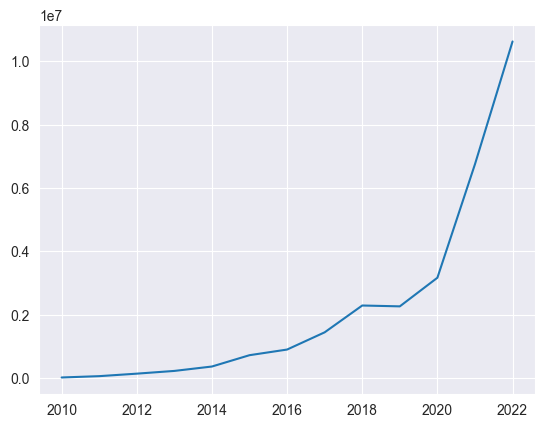

"\n\n\nplt.plot(result)       \nax.xaxis.get_data_interval()\nax.yaxis.get_data_interval()\nax.margins(0.05)\n#plt.tight_layout()\nplt.show() \n\n\nx = np.array([0,1,2,3])\ny = np.array([0.650, 0.660, 0.675, 0.685])\nmy_xticks = ['a', 'b', 'c', 'd']\nplt.xticks(x, my_xticks)\nplt.yticks(np.arange(y.min(), y.max(), 0.005))\nplt.plot(x, y)\nplt.grid(axis='y', linestyle='-')\n"

In [1]:
import pandas as pd
import matplotlib.pyplot as plt


df = pd.read_csv("IEA Global EV Data 2023.csv")

#print(dataset)

#dataset.groupby(["region", "category", "parameter", "mode", "year"])["value"].sum()

#dataset.query("region == 'World'", "category='Historical'", "parameter='EV sales'", "year='2022").groupby(["region", "category", "parameter", "mode", "year"])["value"].sum()
#df.loc[(df['region'] == 'World') & (df['category'] == 'Historical') & (df['parameter'] == 'EV sales')].groupby(["region", "category", "parameter", "year"])["value"].sum()


result = df.loc[(df['region'] == 'World') & (df['category'] == 'Historical') & (df['parameter'] == 'EV sales')].groupby(["year"]).agg(EVSales=('value', 'sum'))


# plotting a line graph 
print("Line graph: ") 
print(result)
#plt.plot(result["year"], result["EVSales"]) 
fig, ax = plt.subplots()
ax.plot(result)

#print(ax.xaxis.get_data_interval())
#print(ax.yaxis.get_data_interval())

plt.show()





'''


plt.plot(result)       
ax.xaxis.get_data_interval()
ax.yaxis.get_data_interval()
ax.margins(0.05)
#plt.tight_layout()
plt.show() 


x = np.array([0,1,2,3])
y = np.array([0.650, 0.660, 0.675, 0.685])
my_xticks = ['a', 'b', 'c', 'd']
plt.xticks(x, my_xticks)
plt.yticks(np.arange(y.min(), y.max(), 0.005))
plt.plot(x, y)
plt.grid(axis='y', linestyle='-')
'''